# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Coupled Soil and Root Hydraulics, including dynamic perirhizal models



If the soil becomes dry, steep gradients in soil matric potential can occur towards the root surface due to root transpiration. A higher resolution of the macroscopic soil model cannot resolve this (Khare et al., 2022) which leads to an overestimation of root water uptake under dry conditions. In the following example, we combine code from previous sections to calculate  water uptake of a static plant in a dynamic soil, including a simulation of the perhirizal domains. The simulation is based on the work of Mai et al. (2019).

In [3]:
import timeit
from functools import partial

import helpful
import matplotlib.pyplot as plt
import numpy as np

import functional.root_conductivities as r_cond
import functional.van_genuchten as vg
import functional.xylem_flux as x_flux  # root system Python hybrid solver
import plantbox as pb  # CPlantBox
import rhizo_models as rm  # Helper class for cylindrical rhizosphere models
import visualisation.vtk_plot as vp
from functional.PlantHydraulicModel import HydraulicModel_Meunier
from functional.PlantHydraulicParameters import PlantHydraulicParameters
from richards import RichardsWrapper  # Python part, macroscopic soil model
from rosi_richards import RichardsSP

sourcedir = "/home/jhack/phd/CPlantBox/"

In [2]:
""" soil """
min_b = [-4., -4., -15.]  # cm
max_b = [4., 4., 0.]  # cm
cell_number = [7, 7, 15]  # [1]
periodic = False
loam = [0.08, 0.43, 0.04, 1.6, 50]
soil_ = loam
soil = vg.Parameters(soil_)
initial = -1000  

""" root system """
path = sourcedir +"modelparameter/structural/rootsystem/"
name = "Zeamays_synMRI_modified" 
trans = 6.4  # average per day [cm3 /day] (sinusoidal)
wilting_point = -15000  # [cm]
rs_age = 6

""" rhizosphere models """
mode = "dumux"  # or "analytical"
NC = 10  # dof+1 (degrees of freedom); number of discretization points along the radial direction
logbase = 1.5  # according to Mai et al. (2019); logarithmically spaced grid; how aggressive spacing increases away from root
split_type = 1 # division of the flow between the perirhizal zones aka how total water flux is divided (0: volume,1: surface, 2: length)

""" simulation time """
sim_time = 0.3 # [day]
dt = 30. / (24 * 3600)  # time step [day]
NT = int(np.ceil(sim_time / dt))  # number of iterations

In [4]:
def soil_picker(x: float, y: float, z: float, soil_model) -> int:
    """
    Maps a 3D coordinate (x, y, z) to the corresponding soil grid cell index.

    This function wraps the Richards solver's `pick()` method, which returns
    the index of the grid cell containing the given coordinates. It is used
    to couple plant root segments to the soil model in CPlantBox simulations.

    Args:
        x (float): X-coordinate [cm].
        y (float): Y-coordinate [cm].
        z (float): Z-coordinate [cm].
        soil_model: The soil model object (e.g. a RichardsWrapper instance).

    Returns:
        int: The index of the soil grid cell containing the point (x, y, z).
    """
    return soil_model.pick([x, y, z])

""" Initialize macroscopic soil model """
s = RichardsWrapper(RichardsSP())
s.initialize()

s.createGrid(min_b, max_b, cell_number, periodic)  # [cm]
s.setHomogeneousIC(initial, True)  # cm pressure head, equilibrium
s.setTopBC("noFlux")
s.setBotBC("noFlux")
s.setVGParameters([soil_])
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True") # ensures solver convergence check is absolute
s.setParameter("Soil.SourceSlope", "1000")  # turns regularisation of the source term on --> important for stability with roots
s.initializeProblem()
s.setCriticalPressure(wilting_point)  # new source term regularisation
s.ddt = 1.e-5  # [day] initial Dumux time step

""" Initialize plant model """
plant = pb.MappedPlant(1) # creates 1 plant
plant.enableExtraNode() # creates extra node at root collar for hydraulic calculations
plant.readParameters(path + name + ".xml")
for p in plant.getOrganRandomParameter(pb.root): # iterates over root segments and controls their lengths
    p.dx = 1
    p.dxMin = 0.1
    
if not periodic:
    sdf = pb.SDF_PlantBox(0.95 * (max_b[0] - min_b[0]), 0.95 * (max_b[1] - min_b[1]), 0.95 * (max_b[2] - min_b[2]))
else:
    sdf = pb.SDF_PlantBox(np.inf, np.inf, max_b[2] - min_b[2])
plant.setGeometry(sdf)

""" Initialize rhizopheric and hydraulic model """
rs = rm.RhizoMappedSegments(plant, wilting_point, NC, logbase, mode) # per-segment rhizosphere objects
#args: plant: MappedPlant, wilting_point: float, NC (number of radial nodes): int, logbase (logarithmic spacing): float, mode (solver type): str = "dumux", split_type: int = 1
params = PlantHydraulicParameters()  
params.read_parameters(sourcedir +"modelparameter/functional/plant_hydraulics/couvreur2012")
hm = HydraulicModel_Meunier(rs.ms, params) # sets up xylem hydraulic network
hm.wilting_point = wilting_point  

""" Coupling (map indices) """
rs.ms.setRectangularGrid(pb.Vector3d(min_b[0], min_b[1], min_b[2]), pb.Vector3d(max_b[0], max_b[1], max_b[2]),
                        pb.Vector3d(cell_number[0], cell_number[1], cell_number[2]), False, False) # defines soil domain extents
picker = partial(soil_picker, soil_model=s)
rs.ms.setSoilGrid(picker)  # maps root segements and soil grid indices to each other in both directions

plant.initialize(True)
plant.simulate(rs_age, True)
hm.test()  # sanity checks

Computed bounding box tree with 1469 nodes for 735 grid entities in 0.00153893 seconds.
Computed bounding box tree with 1469 nodes for 735 grid entities in 0.000485109 seconds.
MappedPlant::initializeLB 
Seed::initialize: RootSystem 
Seed::initialize: Shoot borne definition is DEPRICATED, shoot borne roots will be handeled like basal roots 
Organism::simulate: from 0 to 6 days
nodes moved 0
new nodes added 546
segments added 546
Number of segments 547, including 546 new 
PlantHydraulicModel.test():
548 nodes:
Node 0 [ 0.1  0.  -3. ]
Node 1 [ 0.  0. -3.]
Node 2 [ 1.10500360e-03 -1.14370671e-03 -3.99999874e+00]
Node 3 [ 0.04705323 -0.01098848 -4.37369585]
Node 4 [ 1.00210175 -0.29068372 -4.47194496]
547 segments:
Segment 0 [0 1] subType 0
Segment 1 [1 2] subType 1
Segment 2 [2 3] subType 1
Segment 3 [3 4] subType 2
Segment 4 [4 5] subType 2
Collar segment index 0
Collar segment [0 1]
0 segments with length < 1.e-5 cm
6 different root types from 0 to 5
ages from 0 to 6
segments 547 547



In [ ]:

""" Initialize local soil models (around each root segment) """
start_time = timeit.default_timer() # timer measures initialization time
x = s.getSolutionHead()  # initial condition of soil [cm]
dcyl = len(rs.ms.segments) # total number of root segments

with helpful.StdoutRedirector() as redirector: # make the model creation quiet aka suppress verbose printing
    rs.initialize(soil_, x, np.array(range(dcyl))) # initializes rhizosphere models around each root segment
    # args: soil parameters, initial condition, array of root segment indices

print (f"Initialized [{0:g}-{1:g}] in {2:g} s".format(0, dcyl, timeit.default_timer() - start_time))

initializing look up tables
done
Initialized [0-1] in 2 s


In [ ]:
def sinusoidal(t: float) -> float: # to plot daily variation in transpiration
    """ 
    Sinusoidal function (used for transpiration) (integral over one day is 1).
    
    Args:
        t (float): Time [days].
    
    Returns:
        float: Sinusoidal value at time t.
    """
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.

""" 
Simulation 

loop
1. xylem model
2. local soil models
3. macroscopic soil model 
"""
print("Starting simulation")
start_time = timeit.default_timer()

# monitoring variables for post processing
min_hs, min_hx, min_hsx, collar_flux = [], [], [], []  # cm; hs: soil matric potential, hx: xylem potential, hsx: matric potential at root-soil interface
water_uptake = []  # cm3
out_times = []  # days
cci = picker(rs.ms.nodes[0].x, rs.ms.nodes[0].y, rs.ms.nodes[0].z)  # collar cell index
cell_volumes = s.getCellVolumes()  # cm3
net_flux = np.zeros(cell_volumes.shape)
hsx = rs.get_inner_heads()  # matric potential at the root soil interface, i.e. inner values of the cylindric models [cm]
inner_kr_ = np.divide(vg.hydraulic_conductivity(hsx, soil), rs.ms.radii)  # only valid for homogenous soil; effective radial conductivity at root-soil interface [cm/day]

for i in range(0, NT):

    wall_iteration = timeit.default_timer()
    t = i * dt  # current simulation time

    """ 1. xylem model """
    wall_root_model = timeit.default_timer()
    hx = hm.solve(rs_age + t, -trans * sinusoidal(t), hsx, cells = False, soil_k = inner_kr_)  # [cm]; solve xylem hydraulic network
    proposed_inner_fluxes = hm.radial_fluxes(rs_age + t, hx, hsx, cells = False, soil_k = inner_kr_)  # [cm3/day]; radial water fluxes from soil into each root segment
    wall_root_model = timeit.default_timer() - wall_root_model

    """ 2. local soil models """
    wall_rhizo_models = timeit.default_timer()
    proposed_outer_fluxes = rs.ms.splitSoilFluxes(net_flux / dt, split_type) # [cm3/day]; splits soil fluxes to each root segment according to split_type
    
    rs.solve(dt, proposed_inner_fluxes, proposed_outer_fluxes) # solves 1D partial differential equations in each rhizosphere cylinder
    
    realized_inner_fluxes = rs.get_inner_fluxes() # actual radial fluxes from soil into each root segment after solving rhizosphere models
    hsx = rs.get_inner_heads()  # matric potential at the root soil interface, i.e. inner values of the cylindric models [cm]
    inner_kr_ = np.divide(vg.hydraulic_conductivity(hsx, soil), rs.ms.radii)  # only valid for homogenous soil; update radial conductivity at root-soil interface [cm/day]
    wall_rhizo_models = timeit.default_timer() - wall_rhizo_models

    """ 3a. macroscopic soil model """
    wall_soil_model = timeit.default_timer()
    water_content = np.array(s.getWaterContent()) # soil water content per cell
    soil_water = np.multiply(water_content, cell_volumes)
    soil_fluxes = rs.ms.sumSegFluxes(realized_inner_fluxes)  # [cm3/day] water extracted by root segments; summed per soil cell
    s.setSource(soil_fluxes.copy())  # [cm3/day], in richards.py; applies root water uptake as source term in macroscopic soil PDE (partial differential equation)
    s.solve(dt)  # in solverbase.py

    """ 3b. calculate net fluxes """ # computes actual change in soil water per cell
    water_content = np.array(s.getWaterContent())
    new_soil_water = np.multiply(water_content, cell_volumes)  # calculate net flux
    net_flux = new_soil_water - soil_water  # change in water per cell [cm3]
    for k, root_flux in soil_fluxes.items():
        net_flux[k] -= root_flux * dt

    soil_water = new_soil_water

    wall_soil_model = timeit.default_timer() - wall_soil_model
    wall_iteration = timeit.default_timer() - wall_iteration

    min_hs.append(np.min(s.getSolutionHead()))
    out_times.append(t)
    collar_flux.append(hm.get_transpiration(rs_age + t, hx, hsx, cells = False, soil_k = inner_kr_))
    min_hsx.append(np.min(np.array(hsx)))
    min_hx.append(np.min(np.array(hx)))
    
    summed_soil_fluxes = 0.
    for k, v in soil_fluxes.items():
        summed_soil_fluxes += v
    water_uptake.append(summed_soil_fluxes)  # cm3/day; total water removed from soil at this time step
            
    if i % 10 == 0:
        n = round(float(i) / float(NT) * 100.)
        pct_root = wall_root_model / wall_iteration * 100.
        pct_rhizo = wall_rhizo_models / wall_iteration * 100.
        pct_soil = wall_soil_model / wall_iteration * 100.
        
        print(f"Cylindrical model: minimum root soil interface {min_hsx[-1]:g} cm, soil {min_hs[-1]:g} cm, root xylem {min_hx[-1]:g} cm")
        print(f"Fluxes: summed local fluxes {summed_soil_fluxes:g}, collar flux {collar_flux[-1]:g}, prescribed {-trans * sinusoidal(t):g}")
        print(f"[{'*' * n}{' ' * (100 - n)}] {s.simTime:.3f} days ({n}%)")
        print(f"Iteration {i:g} took {wall_iteration:g} seconds [{pct_root:g}% root, {pct_rhizo:g}% rhizo {pct_soil:g}% soil ]\n")


print (f"Coupled benchmark solved in {timeit.default_timer() - start_time} s")


Starting simulation
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
Cylindrical model: minimum root soil interface -1007.03 cm, soil -1007 cm, root xylem -1007.33 cm
Fluxes: summed local fluxes -1.49293e-12, collar flux 2.05875e-06, prescribed -0
[                                                                                                    ] 0.000 days (0%)
Iteration 0 took 0.604798 seconds [8.55232% root, 55.9728% rhizo 35.474% soil ]

Cylindrical model: minimum root soil interface -1007.11 cm, soil -1007 cm, root xylem -1007.43 cm
Fluxe

/home/jhack/phd/cpbenv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


Cylindrical model: minimum root soil interface -4898.92 cm, soil -2001.14 cm, root xylem -15000 cm
Fluxes: summed local fluxes -5.80826, collar flux -5.75158, prescribed -6.12084
[*********************************************************************************                   ] 0.243 days (81%)
Iteration 700 took 0.253944 seconds [2.61376% root, 85.3217% rhizo 12.0632% soil ]

Cylindrical model: minimum root soil interface -5010.86 cm, soil -2031.97 cm, root xylem -15000 cm
Fluxes: summed local fluxes -5.48724, collar flux -5.55455, prescribed -6.26038
[**********************************************************************************                  ] 0.247 days (82%)
Iteration 710 took 0.240316 seconds [3.5576% root, 85.7784% rhizo 10.6617% soil ]

Cylindrical model: minimum root soil interface -4994.29 cm, soil -2060.66 cm, root xylem -15000 cm
Fluxes: summed local fluxes -5.2176, collar flux -5.57824, prescribed -6.4
[************************************************************

Coupled benchmark solved in 245.0289055229805 s
Cumulative soil uptake 0.812738282912975 [cm^3]


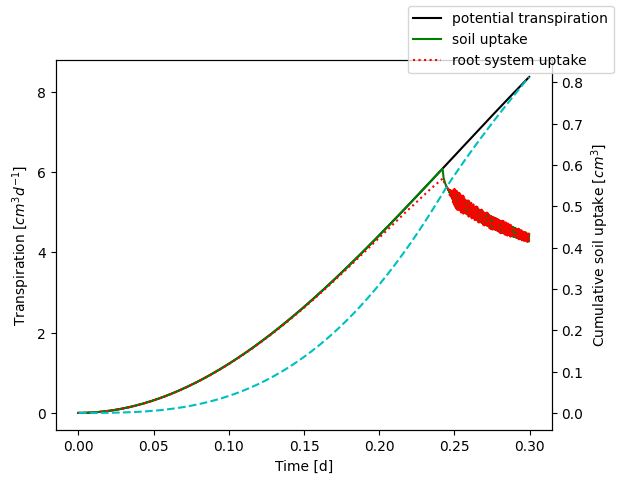

In [ ]:

""" plots and output """
print (f"Coupled benchmark solved in {timeit.default_timer() - start_time} s")
vp.plot_roots_and_soil(rs.ms.mappedSegments(), # root segments with all geometric and hydraulic information
                        "pressure head", # name of the parameter to visualize
                        hsx, # values of that parameter, here: root-soil interface pressure heads [cm]
                        s, # macroscopic soil model object
                        periodic, # periodic True/False
                        min_b, # minimum coordinates
                        max_b, # maximum coordinates
                        cell_number, # number of cells
                        interactiveImage = True)  # VTK vizualisation

rm.plot_transpiration(out_times, water_uptake, collar_flux, lambda t: trans * sinusoidal(t))  # in rhizo_models.py

Plotting the water potential in a specific perirhizal zone:

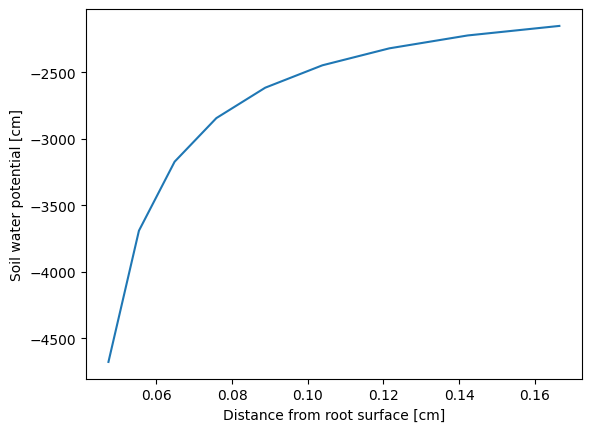

In [8]:
def plot_profile(cc: np.ndarray, h: np.ndarray) -> None:
    """ 
    Plot the radial soil matric potential profile around a root segment.

    Args:
        cc (np.ndarray): Radial distances from root surface [cm].
        h (np.ndarray): Soil matric potential at corresponding distances [cm].

    Returns:
        None: Creates a plot of soil water potential versus distance from the root surface.
    
    Notes:
        - This plot is useful to visualize how water potential changes radially 
          from the root surface into the surrounding soil.
        - The function assumes `cc` and `h` are 1D arrays of the same length.
    """
    fig, ax1 = plt.subplots()
    ax1.plot(cc, h)
    ax1.set_ylabel("Soil water potential [cm]")
    ax1.set_xlabel("Distance from root surface [cm]")

peri_index = np.where(hsx == min(hsx))[0][0] # index of the root segment with the lowest root-soil interface matric potential
peri_zone = rs.cyls[peri_index] # rhizosphere cylinder around that root segment
cc = np.array(peri_zone.getCellCenters()).flatten() # radial distances from root surface [cm]
h_peri = np.array(peri_zone.getSolutionHead()).flatten() # soil matric potential at corresponding distances [cm]
plot_profile(cc, h_peri)